In [ ]:
!pip install bioframe
!pip install git+https://github.com/manzt/hg.git

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[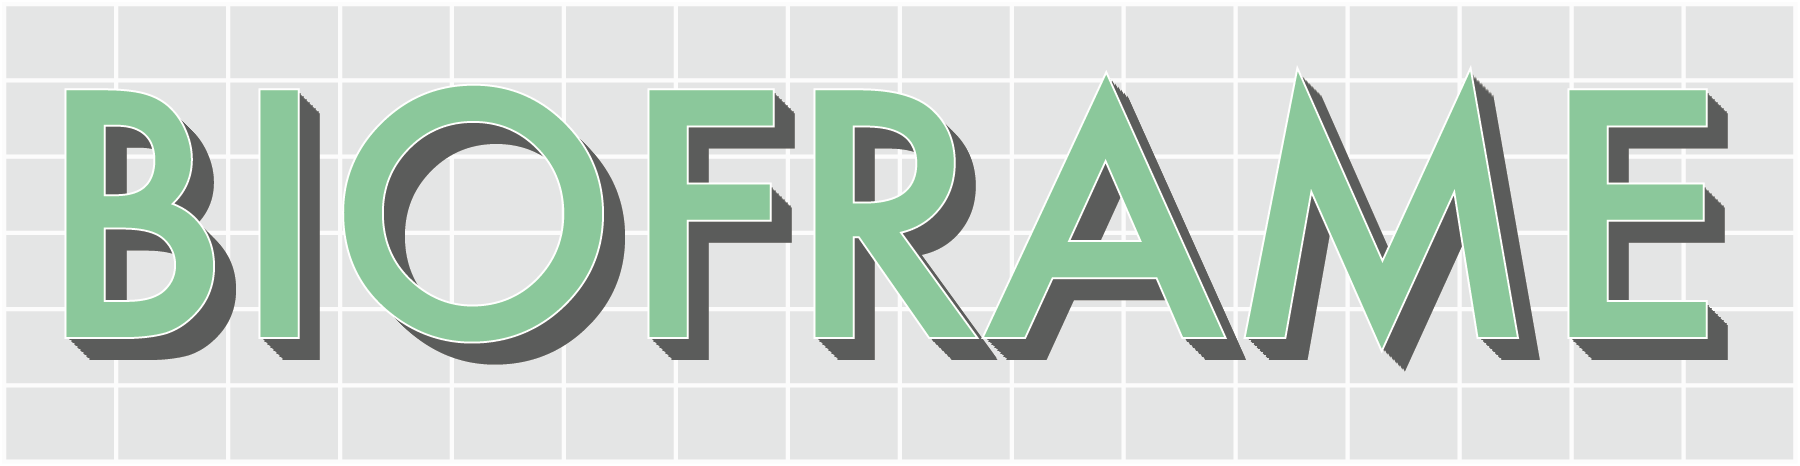](https://github.com/open2c/bioframe)

<center><a href="https://github.com/open2c/bioframe">https://github.com/open2c/bioframe</a></center>

<center><a href="https://bioframe.readthedocs.io">https://bioframe.readthedocs.io</a></center>

<center><a href="https://www.biorxiv.org/content/10.1101/2022.02.16.480748v1">https://www.biorxiv.org/content/10.1101/2022.02.16.480748v1</a></center>

<center><a href="https://bit.ly/open2c-slack">https://bit.ly/open2c-slack</a></center>

## Bioframe enables flexible and scalable operations on Pandas **dataframes** of **genomic intervals**.

### A sequenced genome provides a common **coordinate system** for locating features of interest.

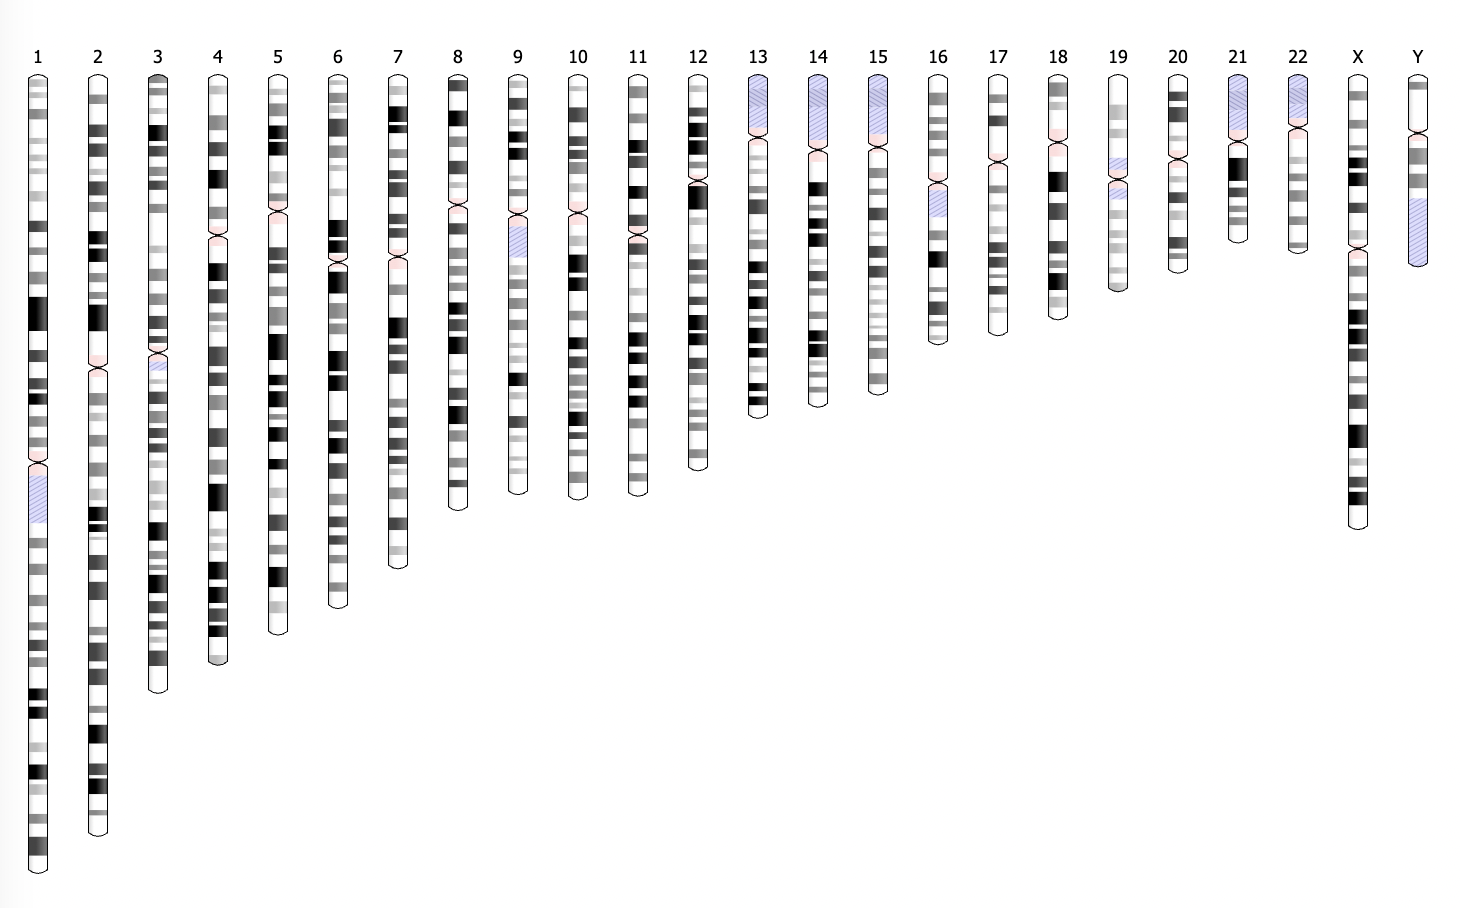

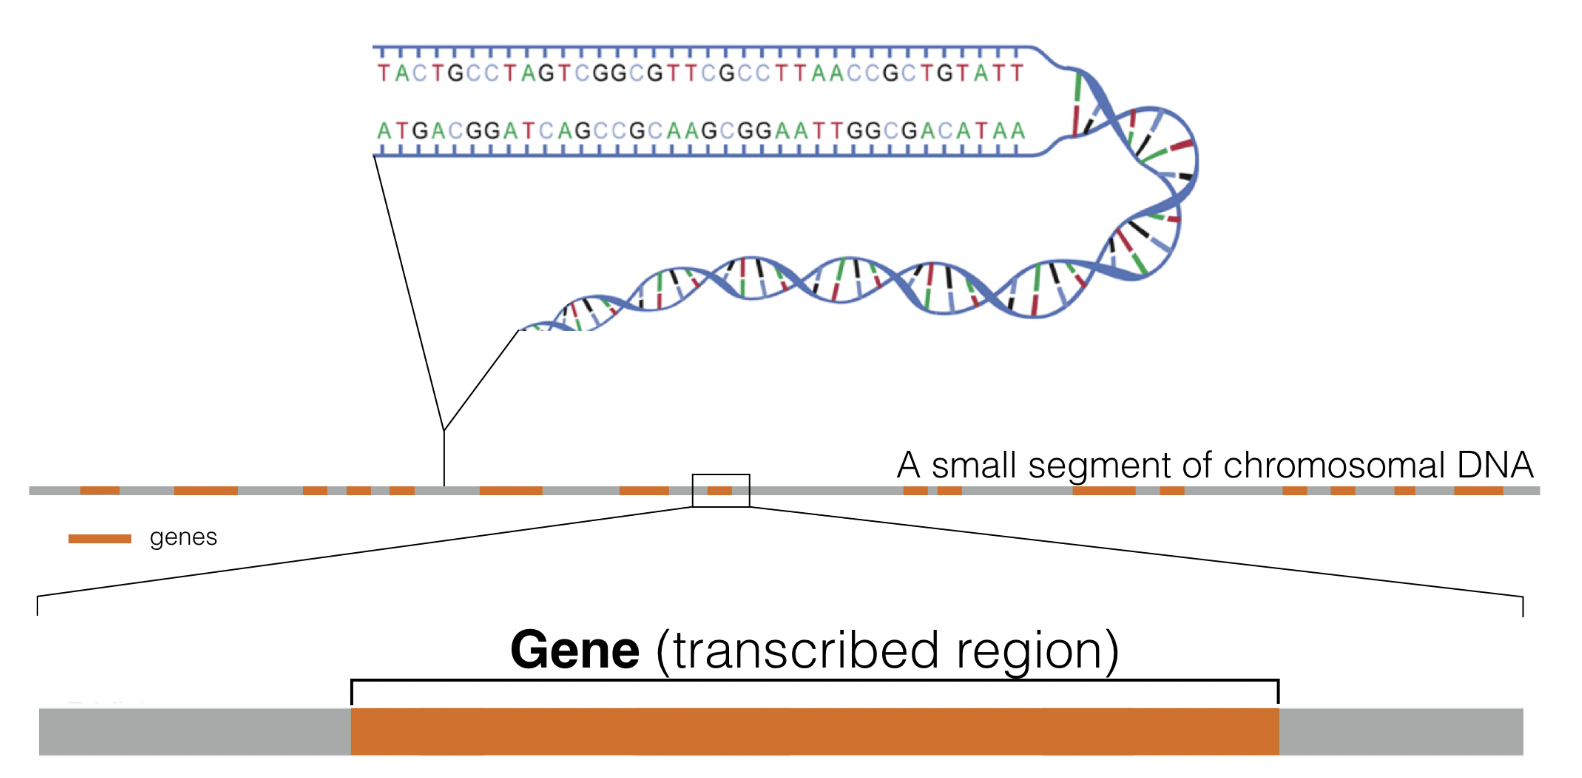

<div style="text-align: center">    
    <sup><sub>Image from <a href="https://bookdown.org/maria_gallegos/where-are-genes/">Fantastic Genes and Where to Find Them</a> by Maria Gallegos
        </sub><sup>
        </div>

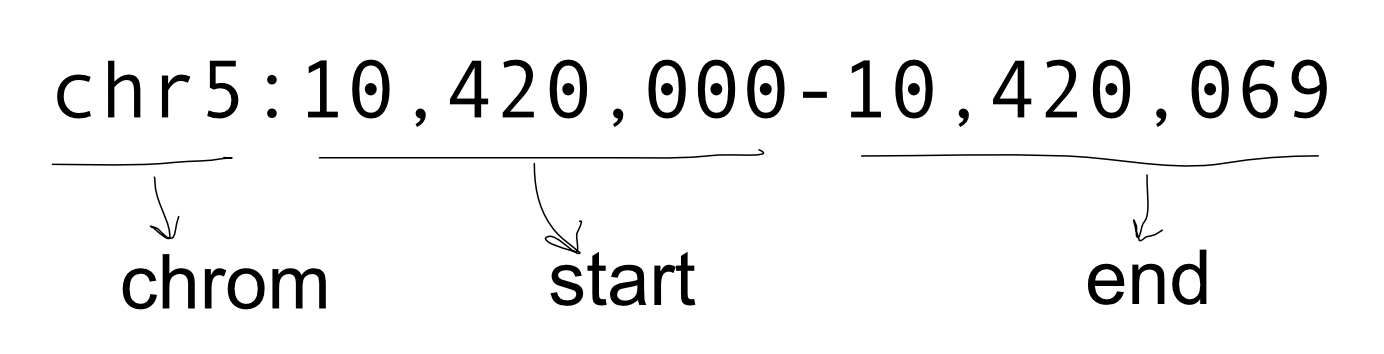

Positions and intervals provide addresses for anything that can be mapped to a [reference genome](https://en.wikipedia.org/wiki/Reference_genome):

* Alignments of short sequencing reads
* Sites of genetic variation
* Individual genes and their substructual components
* Locations occupied by DNA-binding proteins in particular cell types
* And much more!

It is no wonder that positions and intervals are key fields in most genomic data files!

For example, next-generation sequencing (NGS) technologies can map all kinds of functional biomolecular information along this coordinate system.

[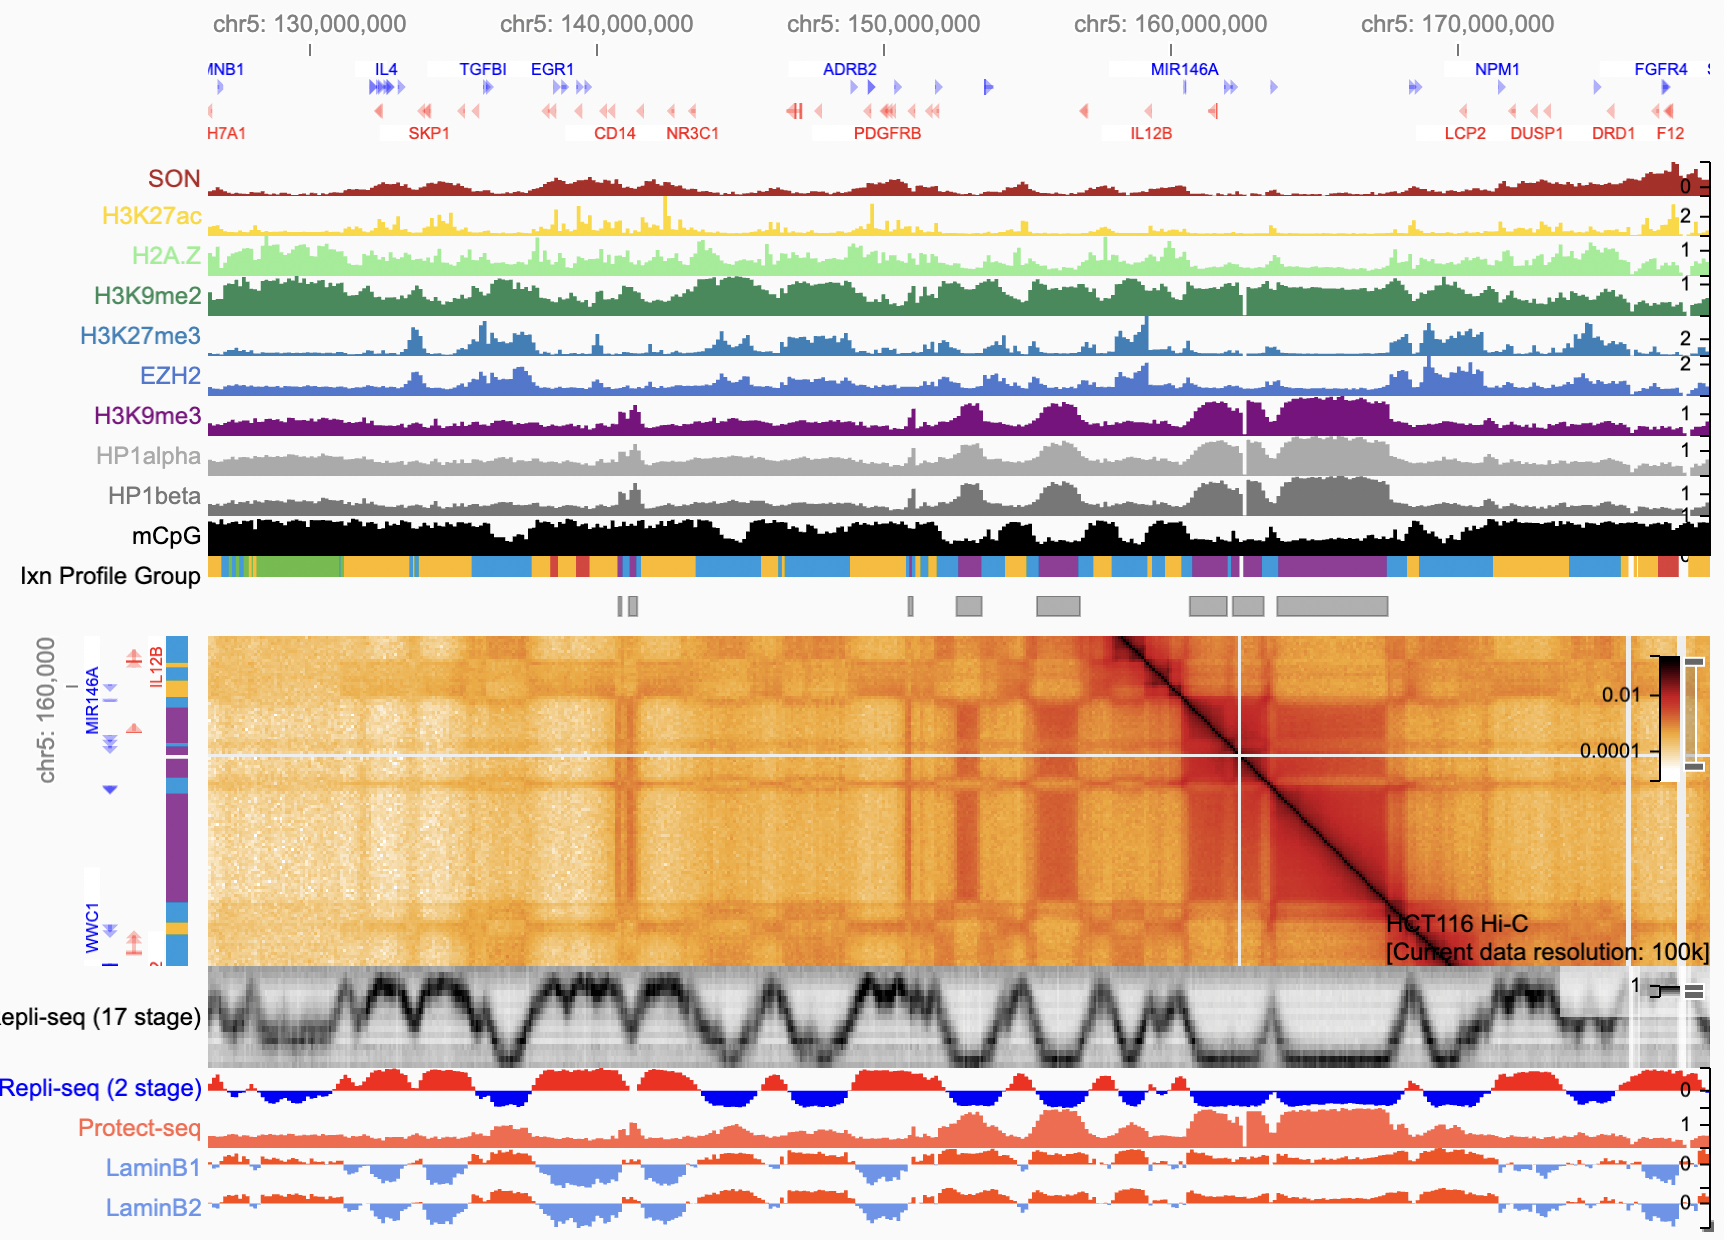](https://resgen.io/l/?d=aicfmfqlS7yDIipohpJfOg)

# Who are we?

<center>We're <a href="https://open2c.github.io">Open2C</a>: The Open Chromosome Collective.</center>

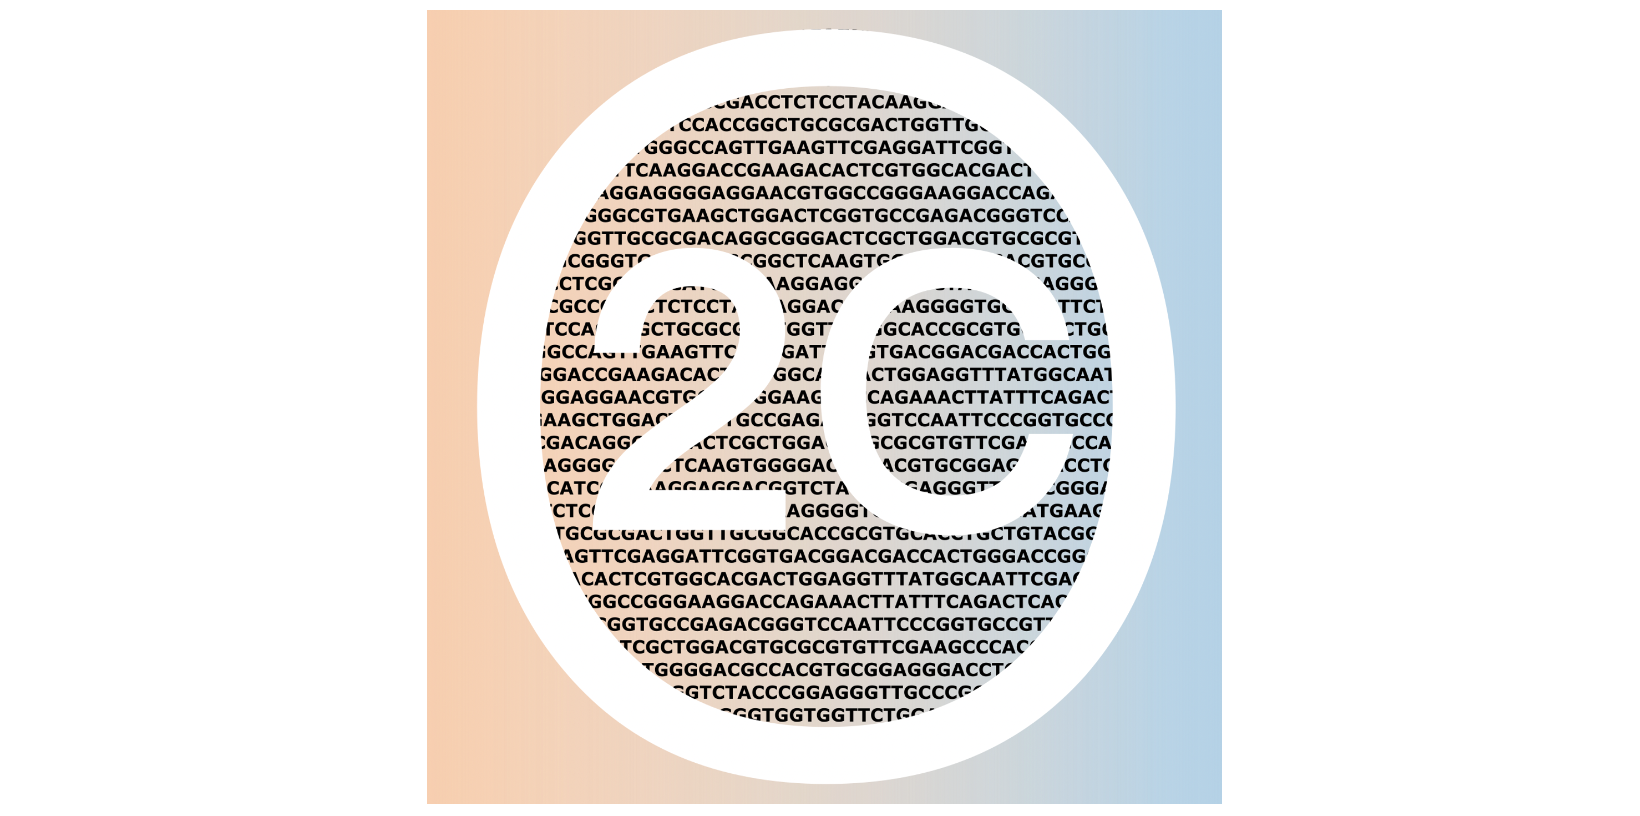


We are a community of **computational biologists** working on chromosome structure and function developing open source tools for the wider community.

# Why Bioframe?

Genomic intervals are one of the most prevalent data structures in computational genome biology. 

**Interval arithmetic** provides a language for asking questions about relationships between features.

There are excellent and widely used command-line tools, such as [BEDTools](https://bedtools.readthedocs.io/en/latest) to perform genome interval arithmetic on common text file formats (e.g. BED).

It also has a Python interface [pyBedTools](https://daler.github.io/pybedtools/)! However, this wrapper package roundtrips data into and out of the command line program through text file intermediates, which is inefficient and imposes unnecessary limitations.

## Can we decouple data processing workflows from cumbersome file formats?

We sought to create a flexible, Pythonic implementation that leverages only `numpy` and `pandas` primitives for speed and vectorization and provides an API smoothly integrated with the Python data ecosystem.

In our implementation, genomic interval sets are just plain old **DataFrames**! 

* No unnecessary serialization/deserialization.
* No opaque wrapper objects.
* No cython or native code to maintain.
* No dataframe subclasses.
* No restrictions on the type or number of additional fields each interval record can contain.

# BED Frames

Any dataframe with `chrom`, `start` and `end` columns satisfying certain properties is considered a "BEDFrame" (the exact column names are configurable). These are the primary objects used by `bioframe`.

The name comes from the Browser Extensible Data (.bed) tsv file format historically designed for the UCSC Genome Browser.

BED Frame coordinates are interpreted as **0-based, half-open**: `[start, end)`. This is analogous to list slices in Python `x[start:stop]`.

In [65]:
import bioframe as bf

df1 = pd.DataFrame([
    ['chr1', 1, 5],
    ['chr1', 3, 8],
    ['chr1', 8, 10],
    ['chr1', 12, 14]],
    columns=['chrom', 'start', 'end']
)
df1

chrom  start  end
0  chr1      1    5
1  chr1      3    8
2  chr1      8   10
3  chr1     12   14

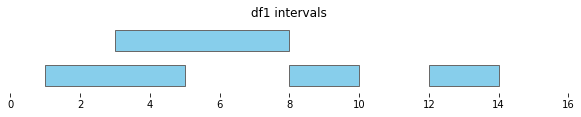

In [141]:
bf.vis.plot_intervals(df1, show_coords=True, xlim=(0, 16))
plt.title('df1 intervals');

In [66]:
df2 = bf.from_any(
    [['chr1', 4, 8],
     ['chr1', 10, 11]], 
    name_col='chrom'
)
df2

chrom  start  end
0  chr1      4    8
1  chr1     10   11

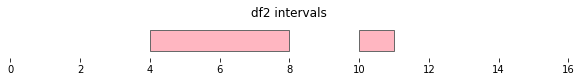

In [142]:
bf.vis.plot_intervals(df2, show_coords=True, xlim=(0, 16), colors='lightpink')
plt.title('df2 intervals');

# View Frames

A more restricted genomic interval dataframe that has several special use cases is a **Genomic View**. Each of its intervals has a unique name (via `name` column) and must have no overlaps. The order of rows is meaningful.

ViewFrames can be used to define entire genomic coordinate systems or specific subsystems of regions.

In [135]:
view_df = pd.DataFrame(
    [["chr1", 0, 4, "chr1p"],  # p-arm of chromosome 1
     ["chr1", 5, 9, "chr1q"],  # q-arm of chromosome 2
     ["chrX", 0, 50, "chrX"],
     ["chrM", 0, 10, "chrM"]],
    columns=["chrom", "start", "end", "name"],
)
view_df

chrom  start  end   name
0  chr1      0    4  chr1p
1  chr1      5    9  chr1q
2  chrX      0   50   chrX
3  chrM      0   10   chrM

In [136]:
# Construct from a chromosome sizes dictionary...
bf.make_viewframe({"chr1": 15, "chr2": 30, "chr3": 9000})

chrom  start   end  name
0  chr1      0    15  chr1
1  chr2      0    30  chr2
2  chr3      0  9000  chr3

# Interval operations

## Overlap

Calculate the overlap occurrences between two BedFrames.

In [30]:
overlaps = bf.overlap(df1, df2, how='inner', suffixes=('_1','_2'))
overlaps

chrom_1  start_1  end_1 chrom_2  start_2  end_2
0    chr1        1      5    chr1        4      8
1    chr1        3      8    chr1        4      8

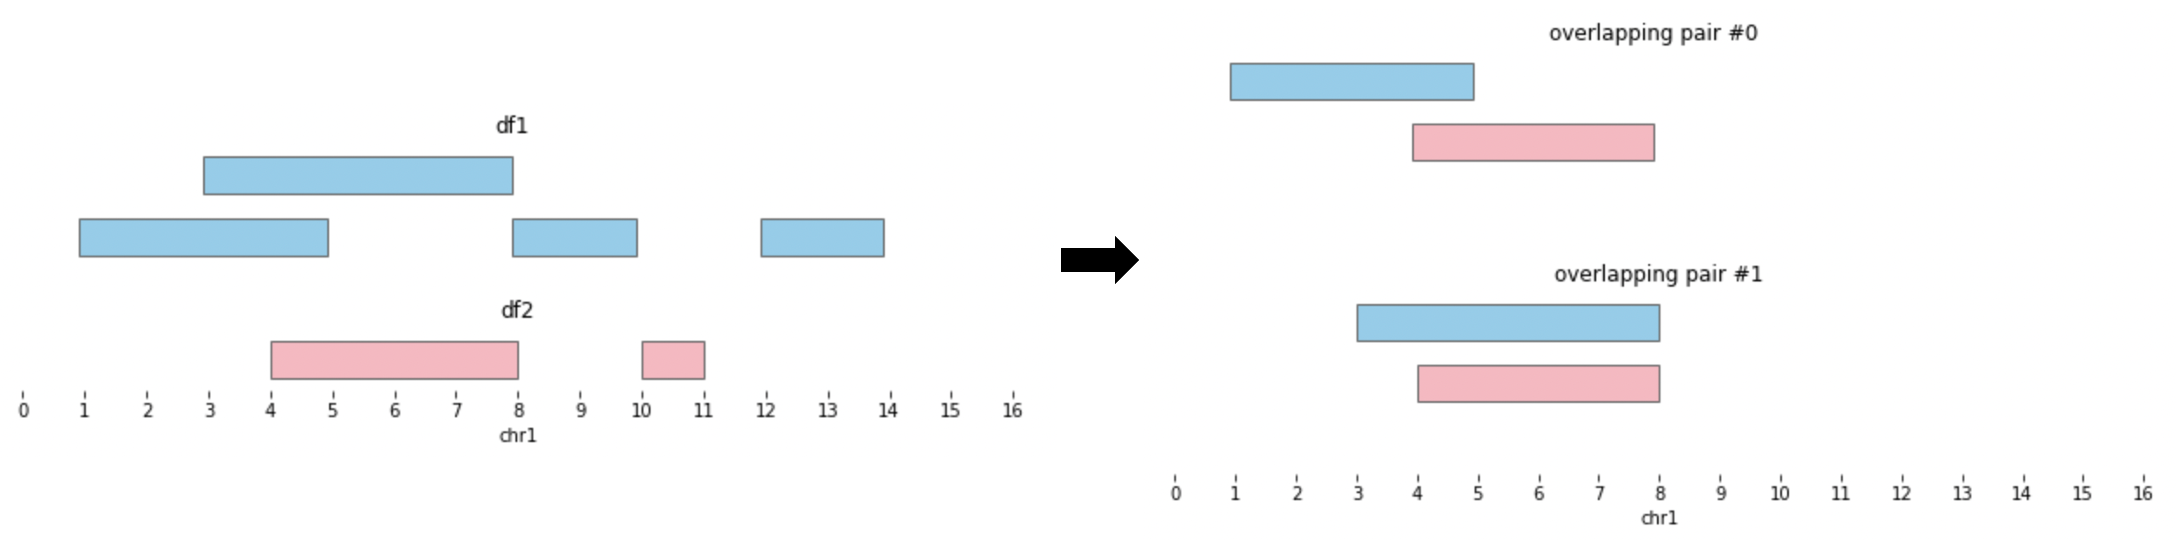

## Cluster

Annotate overlapping groups of intervals with unique cluster IDs.

In [184]:
df_annotated = bf.cluster(df1, min_dist=0)
df_annotated

chrom  start  end  cluster  cluster_start  cluster_end
0  chr1      1    5        0              1           10
1  chr1      3    8        0              1           10
2  chr1      8   10        0              1           10
3  chr1     12   14        1             12           14

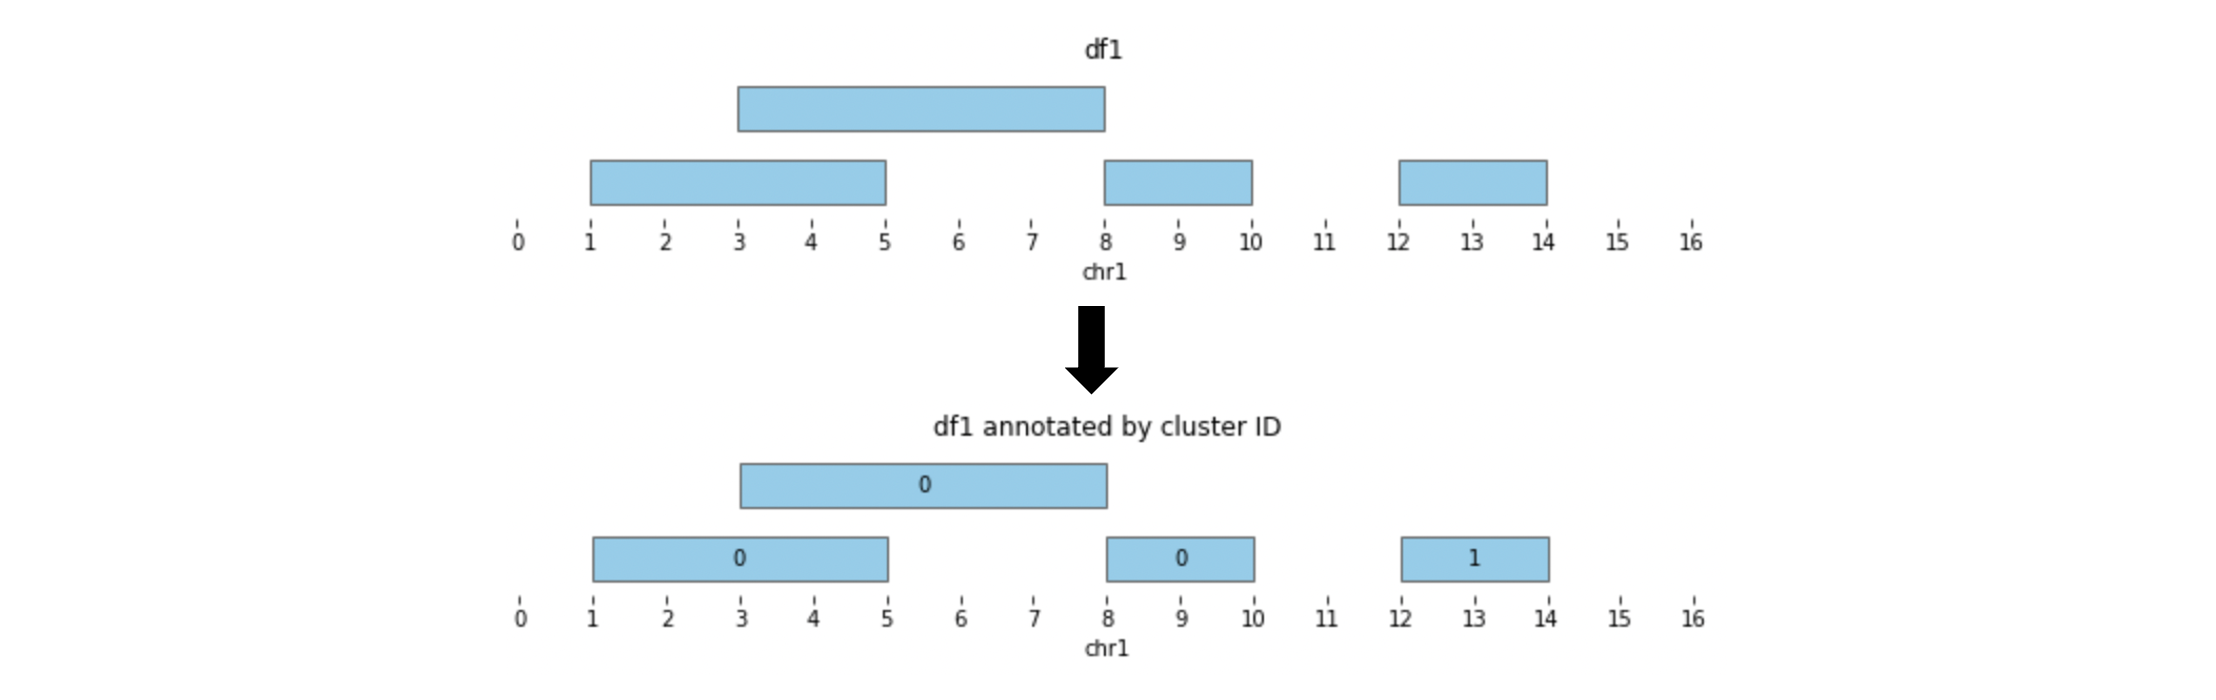

## Merge

Consolidate clusters of overlapping intervals.

In [188]:
df_merged = bf.merge(df1, min_dist=0)
df_merged

chrom  start  end  n_intervals
0  chr1      1   10            3
1  chr1     12   14            1

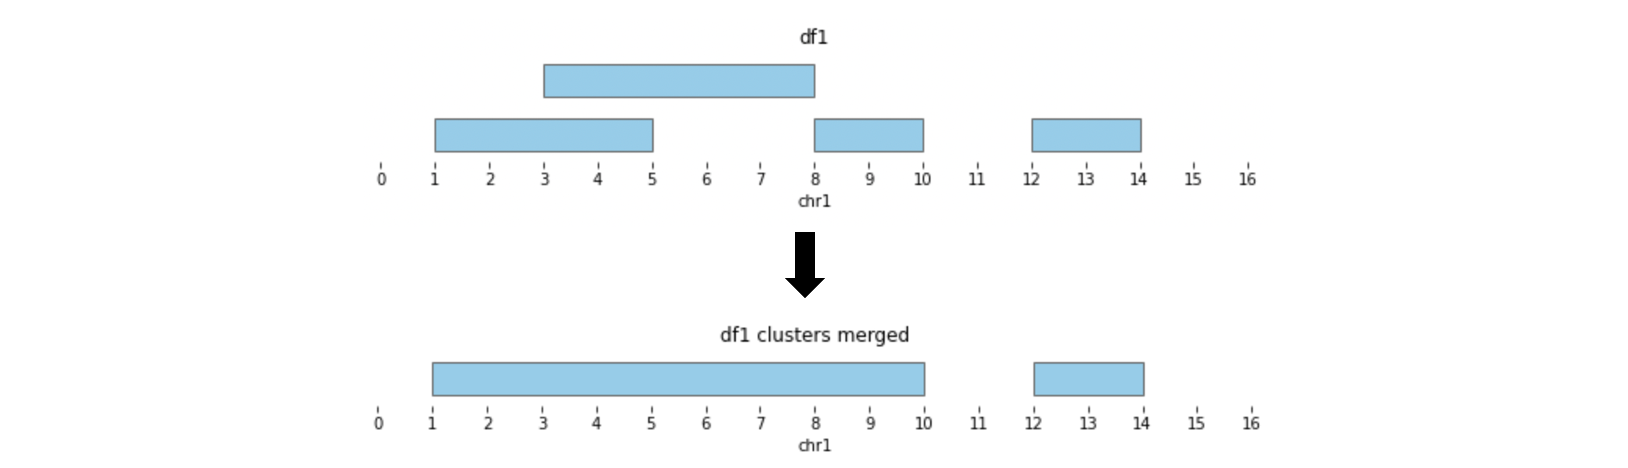

## Closest

It is often useful not only to find features that overlap, but also features that are **nearby** along the genome.

In [194]:
bf.closest(df1, df2, suffixes=('_1','_2'))

chrom_1  start_1  end_1 chrom_2  start_2  end_2  distance
0    chr1        1      5    chr1        4      8         0
1    chr1        3      8    chr1        4      8         0
2    chr1        8     10    chr1        4      8         0
3    chr1       12     14    chr1       10     11         1

In [196]:
df_closest = bf.closest(df1, df2, suffixes=('_1','_2'))

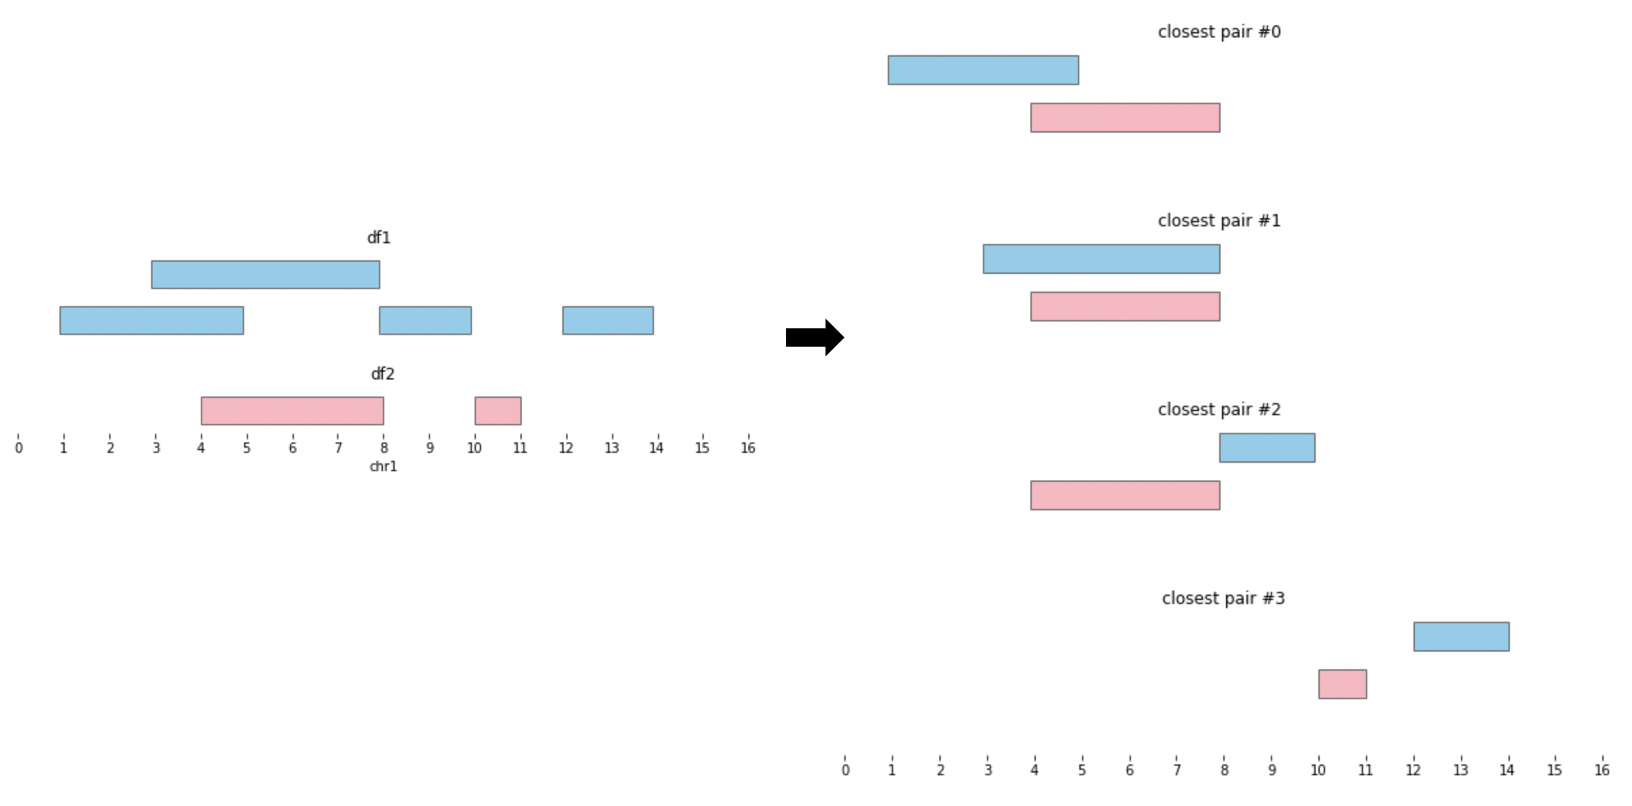

By default, `bioframe.closest` reports overlapping intervals. This can be modified by passing `ignore_overlap=True`. Note the closest pair #2 and #3, which did not overlap, remain the same.

In [197]:
df_closest = bf.closest(df1, df2, ignore_overlaps=True, suffixes=('_1','_2'))

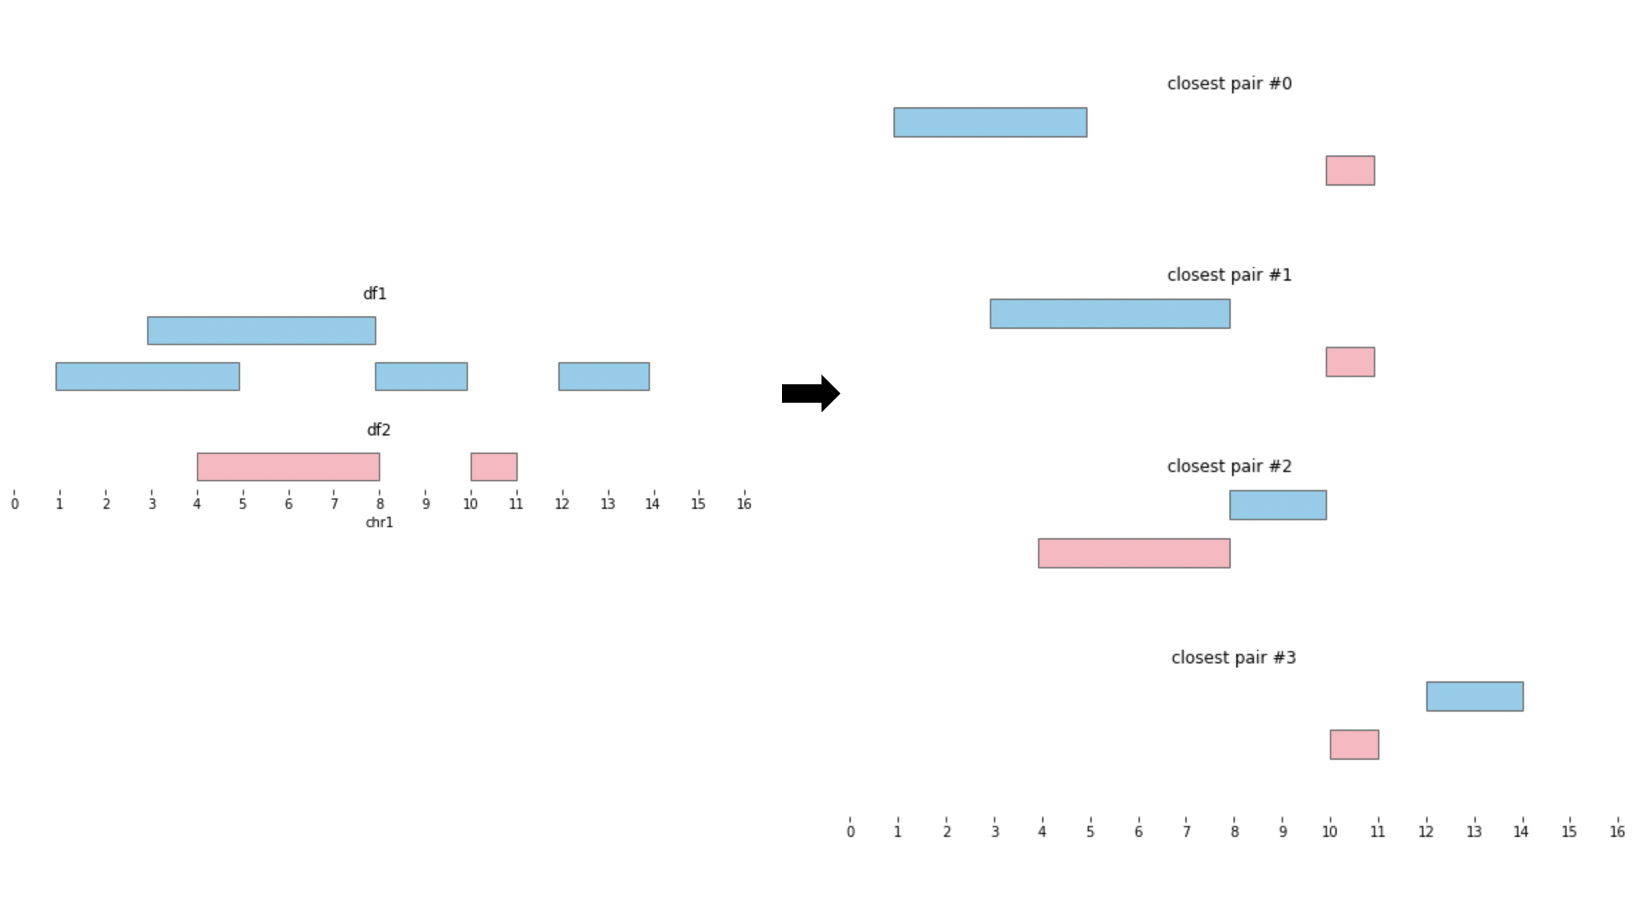

Closest intervals within a single DataFrame can be found simply by passing a single dataframe to `bioframe.closest`. The number of closest intervals to report per query interval can be adjusted with `k`. 

In [116]:
bf.closest(df1, k=2)

chrom  start  end chrom_  start_  end_  distance
0  chr1      1    5   chr1       3     8         0
1  chr1      1    5   chr1       8    10         3
2  chr1      3    8   chr1       1     5         0
3  chr1      3    8   chr1       8    10         0
4  chr1      8   10   chr1       3     8         0
5  chr1      8   10   chr1      12    14         2
6  chr1     12   14   chr1       8    10         2
7  chr1     12   14   chr1       3     8         4

## Subtraction and set difference

Bioframe has two functions for computing differences between sets of intervals: at the level of **basepairs** and at the level of whole **intervals**.

Basepair-level subtraction is performed with `bioframe.subtract`:

In [200]:
subtracted_intervals = bf.subtract(df1, df2)
subtracted_intervals

chrom  start  end
0  chr1      1    4
1  chr1      3    4
2  chr1      8   10
3  chr1     12   14

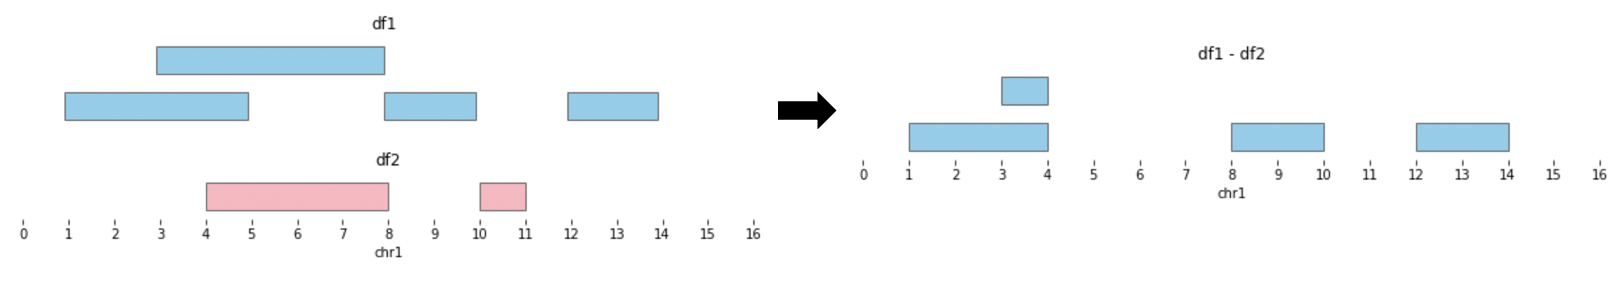

Interval-level differences are calculated with `bioframe.setdiff`:

In [201]:
setdiff_intervals = bf.setdiff(df1, df2)
setdiff_intervals

chrom  start  end
2  chr1      8   10
3  chr1     12   14

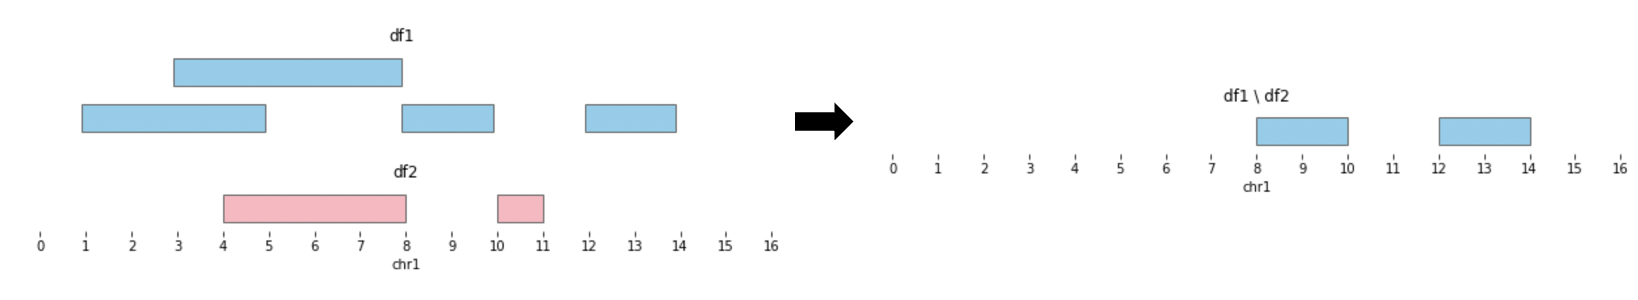

## Coverage and counting overlaps

It is often useful to calculate the **number of basepairs covered** and the **number of overlapping intervals** of one set on another. 

While these are fairly straightforward to compute using `bioframe.overlap` + `pandas.groupby` + column renaming, since these are so frequently used, they are provided as convenience functions.

In [203]:
df1_coverage = bf.coverage(df1, df2)
df1_coverage

chrom  start  end  coverage
0  chr1      1    5         1
1  chr1      3    8         4
2  chr1      8   10         0
3  chr1     12   14         0

In [204]:
df1_coverage_and_count = bf.count_overlaps(df1_coverage, df2)
df1_coverage_and_count

chrom  start  end  coverage  count
0  chr1      1    5         1      1
1  chr1      3    8         4      1
2  chr1      8   10         0      0
3  chr1     12   14         0      0

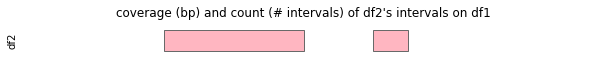

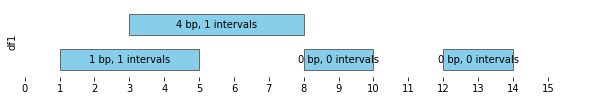

In [205]:
bf.vis.plot_intervals(df2, show_coords=False, xlim=(0,16), colors='lightpink');
plt.title("coverage (bp) and count (# intervals) of df2's intervals on df1");
plt.ylabel("df2");

bf.vis.plot_intervals(
    df1_coverage_and_count, 
    show_coords=True, 
    xlim=(0, 16), 
    labels=[
        f'{cov} bp, {n} intervals' for cov, n in zip(
            df1_coverage_and_count.coverage, 
            df1_coverage_and_count['count']
        )
    ]
)
plt.xticks(range(0, 16));
plt.title("");
plt.ylabel("df1");

## Complement

Returns a BedFrame of intervals not covered by any intervals in an input BedFrame. 

Complements are defined relative to a **genomic view**.

In [125]:
df_complemented = bf.complement(df1, view_df=bf.make_viewframe({'chr1': 15}))
df_complemented

chrom  start  end view_region
0  chr1      0    1        chr1
1  chr1     10   12        chr1
2  chr1     14   15        chr1

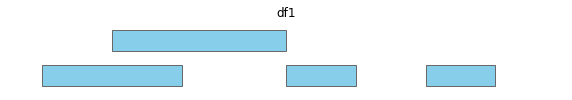

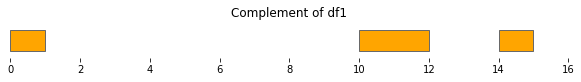

In [131]:
bf.vis.plot_intervals(df1, show_coords=False, xlim=(0, 16))
plt.title('df1');

bf.vis.plot_intervals(
    df_complemented, 
    show_coords=True, 
    xlim=(0, 16), 
    colors='orange'
)
plt.title("Complement of df1");

## Other interval ops

* Expand and trim
* Sorting
* Selecting and slicing
* See [docs](https://bioframe.readthedocs.io/en/latest/api-intervalops.html)

In [ ]:
df_unsorted = pd.DataFrame([
    ['chrM', 3, 8],
    ['chrM', 1, 5],
    ['chrX', 12, 14],
    ['chrX', 8, 10]],
    columns=['chrom', 'start', 'end']
)

bf.sort_bedframe(df_unsorted)

chrom  start  end
0  chrM      1    5
1  chrM      3    8
2  chrX      8   10
3  chrX     12   14

In [ ]:
view_df = pd.DataFrame(
    [
        ["chr1", 0, 4, "chr1p"],
        ["chr1", 5, 9, "chr1q"],
        ["chrX", 0, 50, "chrX"],
        ["chrM", 0, 10, "chrM"]],
    columns=["chrom", "start", "end", "name"],
)
bf.sort_bedframe(df_unsorted, view_df)  # Sort chromosomes, respecting view_df

chrom  start  end
0  chrX      8   10
1  chrX     12   14
2  chrM      1    5
3  chrM      3    8

In [138]:
bioframe.select(df_unsorted,'chrX:8-14')

chrom  start  end
2  chrX     12   14
3  chrX      8   10

In [ ]:
#import hg
#hg.Viewconf.from_url("https://resgen.io/api/v1/viewconfs/Y_omIrpERgG01VsqmtMLVA/?raw=1")

# File I/O and other utilities

Fetch the lengths of a reference human genome assembly.

In [206]:
chromsizes = bf.fetch_chromsizes("hg38")
chromsizes

chr1     248956422
chr2     242193529
chr3     198295559
chr4     190214555
chr5     181538259
chr6     170805979
chr7     159345973
chr8     145138636
chr9     138394717
chr10    133797422
chr11    135086622
chr12    133275309
chr13    114364328
chr14    107043718
chr15    101991189
chr16     90338345
chr17     83257441
chr18     80373285
chr19     58617616
chr20     64444167
chr21     46709983
chr22     50818468
chrX     156040895
chrY      57227415
chrM         16569
Name: length, dtype: int64

Generate a table of uniformly-spaced genomic bins.

In [207]:
bf.binnify(chromsizes, 50_000)

chrom     start       end
0      chr1         0     50000
1      chr1     50000    100000
2      chr1    100000    150000
3      chr1    150000    200000
4      chr1    200000    250000
...     ...       ...       ...
61771  chrY  57050000  57100000
61772  chrY  57100000  57150000
61773  chrY  57150000  57200000
61774  chrY  57200000  57227415
61775  chrM         0     16569

[61776 rows x 3 columns]

Many common TSV schemas derived from the BED format exist in the wild.
Most of them do not possess a header line, as the BED format forbids headers.

`bioframe.read_table` knows a large number of commonly used TSV schemas and provides appropriate names for their fields.

In [208]:
bf.read_table(
    "https://www.encodeproject.org/files/ENCFF114VAI/@@download/ENCFF114VAI.bed.gz", 
    schema="narrowPeak"
)

chrom      start        end name  score strand          fc  -log10p  \
0      chr3   45065046   45065581    .   1000      .  1376.13877     -1.0   
1      chr6   15896006   15896445    .   1000      .   698.21485     -1.0   
2     chr17   78272316   78272810    .   1000      .   669.52158     -1.0   
3     chr22   20981863   20982250    .   1000      .   662.96820     -1.0   
4      chr6  146887472  146887877    .   1000      .   656.19486     -1.0   
...     ...        ...        ...  ...    ...    ...         ...      ...   
9954   chr4    7754313    7754757    .    793      .    16.35491     -1.0   
9955  chr16   67227320   67227764    .    615      .    16.35411     -1.0   
9956  chr21   34202097   34202541    .    800      .    16.35396     -1.0   
9957   chr5   78916303   78916747    .    825      .    16.35277     -1.0   
9958   chr8   94749117   94749561    .    643      .    16.35265     -1.0   

      -log10q  relSummit  
0     3.10619        283  
1     3.10619        240  
2     3.10619        268  
3     3.10619        168  
4     3.10619        206  
...       ...        ...  
9954 -0.00209        222  
9955 -0.00211        222  
9956 -0.00212        222  
9957 -0.00211        222  
9958 -0.00210        222  

[9959 rows x 10 columns]

See [docs](https://bioframe.readthedocs.io/en/latest/api-fileops.html) for more!

# Performance

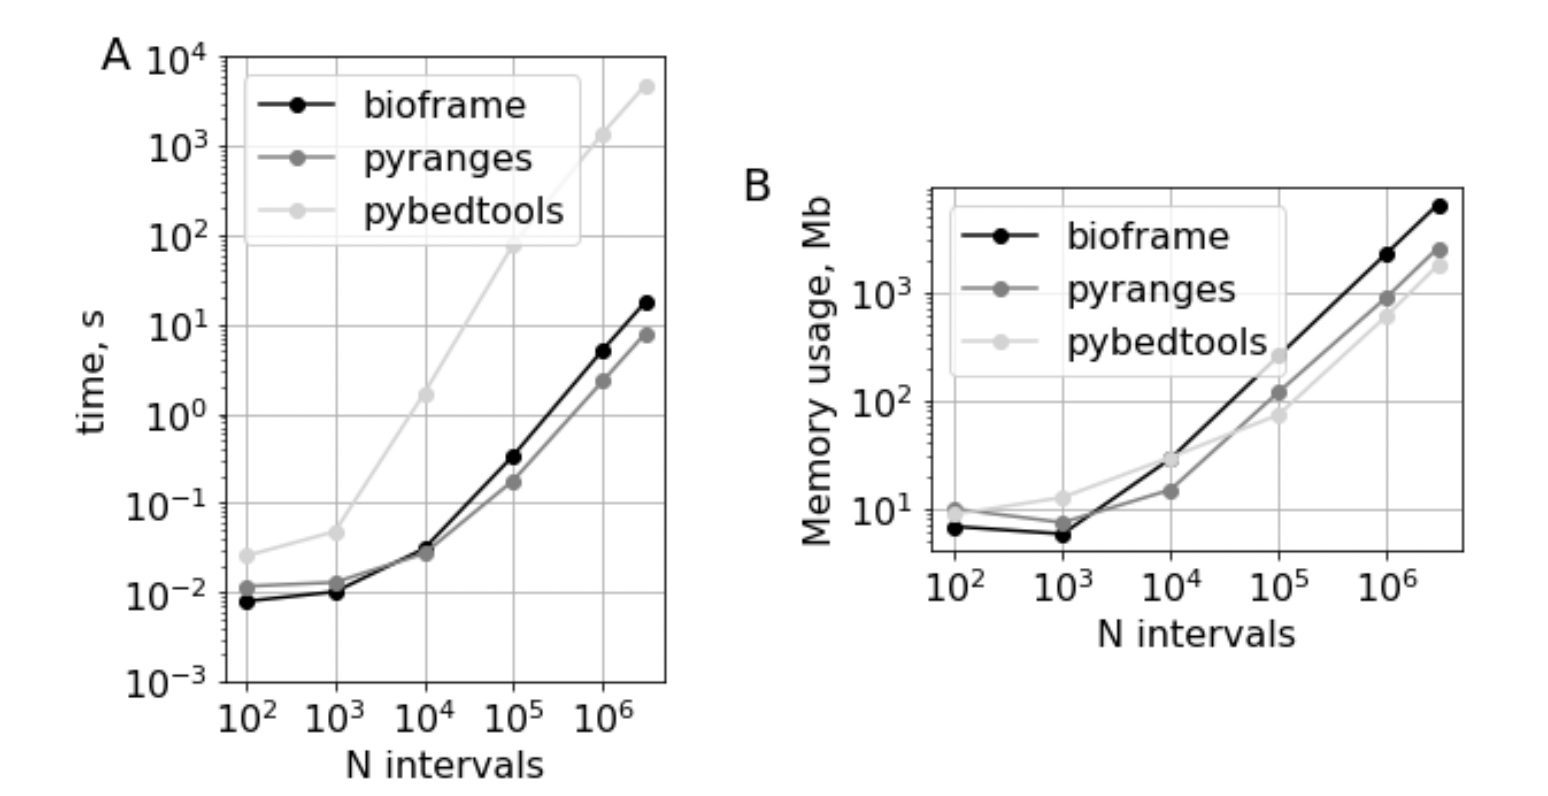

Performance comparison of bioframe, PyRanges, and pybedtools for detecting overlapping intervals between pairs of dataframes of randomly generated genomic intervals. 

(A) Run time and (B) peak memory consumption of bioframe overlap vs. PyRanges join show comparable performance up to millions of intervals. Pybedtools intersect shows slower performance and comparable memory usage. 

Code for this performance comparison is available at https://bioframe.readthedocs.io/en/latest/guide-performance.html

## Example workflow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/open2c/bioframe/blob/main/docs/tutorials/tutorial_assign_motifs_to_peaks.ipynb)

## Bioframe for application programming

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/open2c/bioframe-poster/blob/main/example-app.ipynb)

# For more information

* Read the bioframe [documentation](https://bioframe.readthedocs.io)
* Check us out on [GitHub](https://github.com/open2c/bioframe)
* Follow us on [Twitter](https://twitter.com/Open2C_team)
* Join Open2C on [Slack](https://bit.ly/open2c-slack)!


Interested tackling large-scale software challenges in **computational biology** and **genomics**?

Get in touch!

* 📧 nezar.abdennur@umassmed.edu
* 🌐 https://abdenlab.org
* GitHub: [nvictus](https://github.com/nvictus)
* Twitter: [nv1ctus](https://twitter.com/nv1ctus)
